# 08 Replicating papers

In [75]:
from helper_functions import accuracy_fn, download_data, plot_decision_boundary, plot_loss_curves, plot_predictions, set_seeds
# from helper_functions import download_data, set_seeds, plot_loss_curves
from going_modular import engine, data_loaders
from going_modular import predictions
from going_modular.engine import train_step, test_step
from going_modular.utils import save_model
import mlxtend
from mlxtend.plotting import plot_confusion_matrix
import numpy as np
import os
import pandas as pd
from pathlib import Path

import matplotlib.pyplot as plt
import pandas as pd
from PIL import Image
import random
import requests
import sklearn
from sklearn.datasets import make_circles
from sklearn.datasets import make_moons
from sklearn.model_selection import train_test_split
from sklearn.datasets import make_blobs
from torchinfo import summary
import torch
from torch import nn
from torch.utils.tensorboard import SummaryWriter
from torchmetrics import Accuracy, ConfusionMatrix
import torchvision
from torchvision import datasets

from torchvision import transforms
from torchvision.transforms import ToTensor
from torch.utils.data import DataLoader, Dataset
from timeit import default_timer as timer
from tqdm.auto import tqdm
from typing import Tuple, Dict, List
writer = SummaryWriter()
import zipfile



In [2]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [3]:
image_path = Path('../data/pizza_steak_sushi_20_percent')
train_dir = image_path/'train'
test_dir = image_path/'test'

In [4]:
IMG_SIZE = 224
manual_transform = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor()
])
print(f'Manually Created Transfomrs {manual_transform}')

Manually Created Transfomrs Compose(
    Resize(size=(224, 224), interpolation=bilinear, max_size=None, antialias=True)
    ToTensor()
)


In [5]:
BATCH_SIZE = 32

train_dataloader, test_datloader, class_names = data_loaders.create_dataloaders(
    train_dir=train_dir,
    test_dir = test_dir,
    transform = manual_transform,
    batch_size = BATCH_SIZE
)

train_dataloader, test_datloader, class_names

(<torch.utils.data.dataloader.DataLoader at 0x22f08ea3e10>,
 ['pizza', 'steak', 'sushi'])

In [6]:
image_batch, label_batch = next (iter(train_dataloader))
image, label = image_batch[0], label_batch[0]
image.shape, label

(torch.Size([3, 224, 224]), tensor(1))

(-0.5, 223.5, 223.5, -0.5)

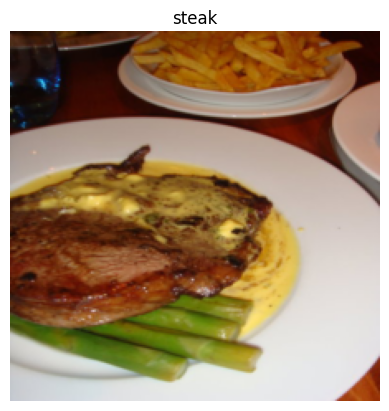

In [7]:
plt.imshow(image.permute(1, 2, 0))
plt.title (class_names[label])
plt.axis(False)

## 4.1 Caluclating patch embedding

In [8]:
height = 224
width = 225
color_channels = 3
patch_size = 16

number_of_patches = int((height * width)/(patch_size **2))
print (f'number patches height (H={height}, width = (W={width}) patch size (P= {patch_size}): {number_of_patches})')

number patches height (H=224, width = (W=225) patch size (P= 16): 196)


In [9]:
embedding_layer_input_shape = (height, width, color_channels)
embedding_layer_input_shape = (number_of_patches, patch_size**2 * color_channels)
print (f'Input Shapem (single 2D imge){embedding_layer_input_shape}')
print (f'Output shape (single 2D image flattened input patches ): {embedding_layer_input_shape}')

Input Shapem (single 2D imge)(196, 768)
Output shape (single 2D image flattened input patches ): (196, 768)


## 4.2 Turning a single image input patches


(-0.5, 223.5, 223.5, -0.5)

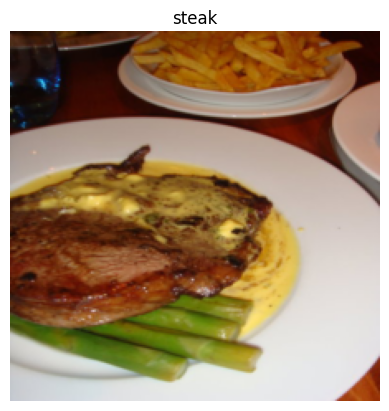

In [10]:
plt.imshow (image.permute(1, 2, 0))
plt.title (class_names[label])
plt.axis (False )

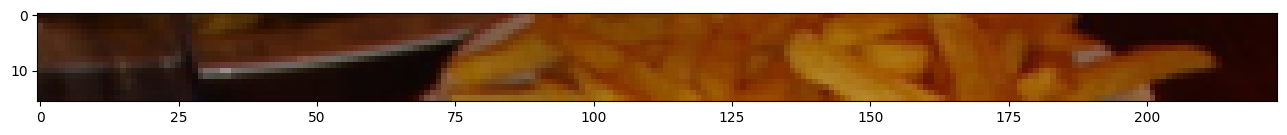

In [11]:
image_permuted = image.permute(1,2, 0)
patch_size= 16
plt.figure(figsize=(patch_size, patch_size))
plt.imshow(image_permuted[:patch_size, :, :])

Number of patchates pers row: 14.0
Patch size: 16 pixel x 16 pixesl


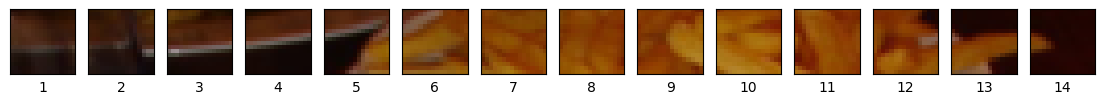

In [12]:
img_size = 224
patch_size = 16
num_patches = img_size/patch_size
assert img_size % patch_size == 0, "image size must be divisible by patch size"
print (f'Number of patchates pers row: {num_patches}\nPatch size: {patch_size} pixel x {patch_size} pixesl')

fig, axs = plt.subplots(nrows = 1,
                       ncols = img_size// patch_size,
                       figsize = (num_patches, num_patches),
                       sharex = True,
                       sharey = True)

for i, patch in enumerate (range (0, img_size, patch_size)):
    axs[i].imshow (image_permuted[:patch_size, patch:patch+patch_size, :]);
    axs[i].set_xlabel(i + 1)
    axs[i].set_xticks([])
    axs[i].set_yticks([])

Number of patches per row: 14.0        
Number of patches per column: 14.0        
Total patches: 196.0        
Patch size: 16 pixels x 16 pixels


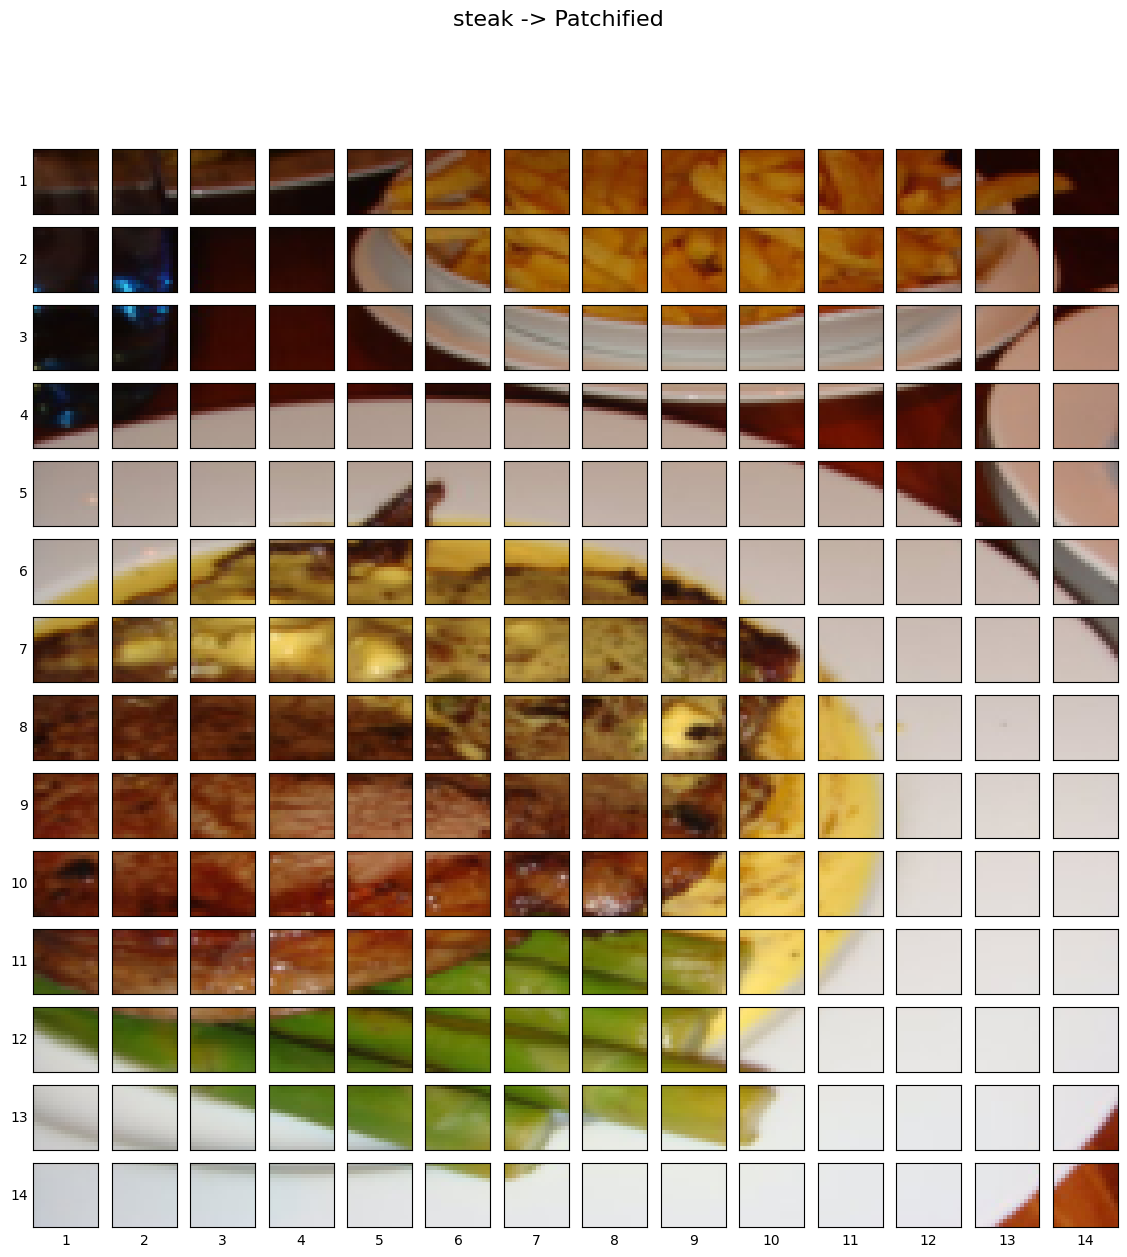

In [13]:
img_size = 224
patch_size = 16
num_patches= img_size/patch_size
assert img_size % patch_size == 0, 'img size nneds'
print(f"Number of patches per row: {num_patches}\
        \nNumber of patches per column: {num_patches}\
        \nTotal patches: {num_patches*num_patches}\
        \nPatch size: {patch_size} pixels x {patch_size} pixels")

fig, axs = plt.subplots (nrows = img_size//patch_size,
                        ncols = img_size// patch_size,
                        figsize = (num_patches, num_patches),
                        sharex = True,
                        sharey = True)

for i, patch_height in enumerate(range(0, img_size, patch_size)):
    for j, patch_width in enumerate(range (0, img_size, patch_size)):
        axs [i, j].imshow(image_permuted[patch_height:patch_height+patch_size,
                                         patch_width:patch_width+patch_size,
                                         :])
        axs[i, j].set_ylabel (i + 1,
                              rotation = 'horizontal',
                              horizontalalignment = 'right',
                              verticalalignment = 'center')
        axs[i, j].set_xlabel (j + 1)
        axs [i, j].set_xticks([])
        axs [i, j].set_yticks([])
        axs[i, j].label_outer()

fig.suptitle(f'{class_names[label]} -> Patchified', fontsize = 16)
plt.show()

## 4.3 Creating image pactecsh with torch.nn.Conv2d()

In [14]:
patch_size = 16
conv2d= nn.Conv2d(in_channels = 3,
                  out_channels = 768,
                  kernel_size = patch_size,
                  stride=patch_size,
                  padding = 0)

(-0.5, 223.5, 223.5, -0.5)

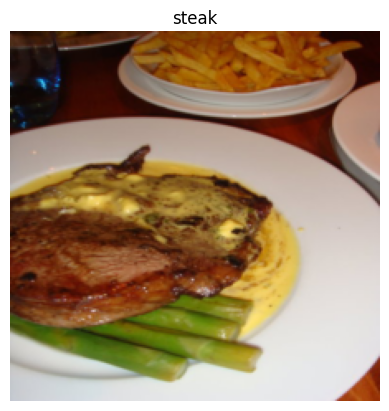

In [15]:
plt.imshow (image.permute(1, 2, 0))
plt.title(class_names[label])
plt.axis(False)

In [16]:
image_out_of_conv = conv2d(image.unsqueeze(0))
print (image_out_of_conv.shape)

torch.Size([1, 768, 14, 14])


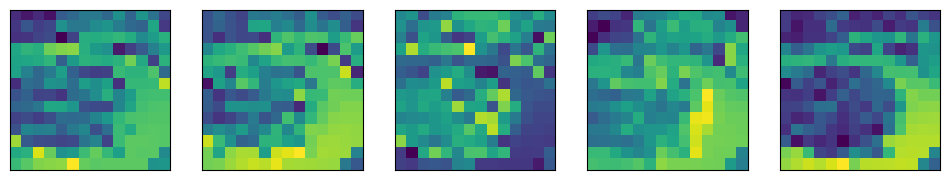

In [17]:
random_indicies = random.sample (range(0, 758), k = 5)
fig, axs = plt.subplots(nrows = 1, ncols =5, figsize = (12, 12))
# for i, idx in enumerate(random_indicies):
#     image_conv_feature_map = image_out_of_conv[:, idx, :]
#     axs[i].imshow(image_conv_feature_map.squeeze().detach().numpy())
#     axs[i].set(xticklabels = [], yticklabel=[], xticks = [], yticks=[])

for i, idx in enumerate(random_indicies):
    image_conv_feature_map = image_out_of_conv[:, idx,:, :]
    axs[i].imshow(image_conv_feature_map.squeeze().detach().numpy())  # Display the image using plt.imshow
    axs[i].set(xticklabels=[], yticklabels=[], xticks=[], yticks=[])

plt.show() 

In [18]:
single_feature_map = image_out_of_conv[:, 0, :, :]
single_feature_map, single_feature_map.requires_grad

(tensor([[[ 0.0686,  0.0342,  0.0271, -0.0055,  0.1451,  0.1107,  0.1625,
            0.1493,  0.1085,  0.1670,  0.1347,  0.1624,  0.2075,  0.0665],
          [ 0.0960,  0.0526,  0.0461,  0.0712,  0.0921,  0.1759,  0.1517,
            0.1681,  0.1302,  0.0941,  0.1184,  0.1030,  0.2257,  0.0577],
          [ 0.0433,  0.0450,  0.0556,  0.0800, -0.1223,  0.0530,  0.2433,
            0.3172,  0.3609,  0.3702,  0.2633,  0.2975,  0.2047,  0.2673],
          [ 0.1749,  0.3715,  0.3331,  0.3813,  0.4243,  0.4393,  0.3559,
            0.3469,  0.2055,  0.1088,  0.0452,  0.0993,  0.0327,  0.2465],
          [ 0.2674,  0.2831,  0.2951,  0.3225,  0.1939,  0.1196,  0.2869,
            0.3134,  0.3065,  0.3252,  0.4305,  0.3678, -0.1479,  0.3017],
          [ 0.3561,  0.1174,  0.1548,  0.1977,  0.2074, -0.0288, -0.0187,
           -0.0414, -0.0272,  0.2983,  0.3276,  0.3243,  0.5194,  0.0479],
          [ 0.0627, -0.0335,  0.0966,  0.1712,  0.2811,  0.1010,  0.2230,
            0.1627,  0.2667, -0.

In [19]:
print (f'current tensor shape: {image_out_of_conv.shape}')

current tensor shape: torch.Size([1, 768, 14, 14])


In [20]:
flatten = nn.Flatten(start_dim = 2,
                     end_dim = 3)

oringital shape: torch.Size([3, 224, 224])
original image shape: torch.Size([1, 768, 14, 14])
flattended feature map shape torch.Size([1, 768, 196])


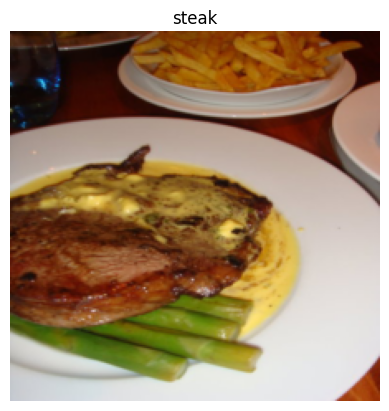

In [21]:
plt.imshow(image.permute(1, 2, 0))
plt.title (class_names[label])
plt.axis(False)
print (f'oringital shape: {image.shape}')

image_out_of_conv = conv2d(image.unsqueeze(0))
print (f'original image shape: {image_out_of_conv.shape}')

image_out_of_conv_flattend = flatten(image_out_of_conv)
print (f'flattended feature map shape {image_out_of_conv_flattend.shape}')


In [22]:
image_out_of_conv_flattend_reshaped = image_out_of_conv_flattend.permute(0, 2, 1)
print (f'Patch embedding squence  shape : {image_out_of_conv_flattend_reshaped.shape}')

Patch embedding squence  shape : torch.Size([1, 196, 768])


(-0.5, 195.5, 0.5, -0.5)

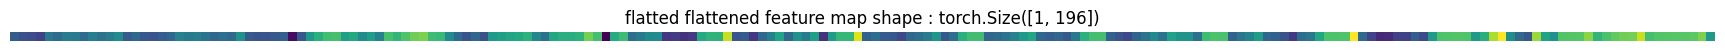

In [23]:
single_flattened_feature_map = image_out_of_conv_flattend_reshaped[:, :, 0]
plt.figure (figsize=(22, 22))
plt.imshow(single_flattened_feature_map.detach().numpy())
plt.title(f'flatted flattened feature map shape : {single_flattened_feature_map.shape}')
plt.axis(False)

In [24]:
single_feature_map,single_feature_map.requires_grad, single_flattened_feature_map.shape

(tensor([[[ 0.0686,  0.0342,  0.0271, -0.0055,  0.1451,  0.1107,  0.1625,
            0.1493,  0.1085,  0.1670,  0.1347,  0.1624,  0.2075,  0.0665],
          [ 0.0960,  0.0526,  0.0461,  0.0712,  0.0921,  0.1759,  0.1517,
            0.1681,  0.1302,  0.0941,  0.1184,  0.1030,  0.2257,  0.0577],
          [ 0.0433,  0.0450,  0.0556,  0.0800, -0.1223,  0.0530,  0.2433,
            0.3172,  0.3609,  0.3702,  0.2633,  0.2975,  0.2047,  0.2673],
          [ 0.1749,  0.3715,  0.3331,  0.3813,  0.4243,  0.4393,  0.3559,
            0.3469,  0.2055,  0.1088,  0.0452,  0.0993,  0.0327,  0.2465],
          [ 0.2674,  0.2831,  0.2951,  0.3225,  0.1939,  0.1196,  0.2869,
            0.3134,  0.3065,  0.3252,  0.4305,  0.3678, -0.1479,  0.3017],
          [ 0.3561,  0.1174,  0.1548,  0.1977,  0.2074, -0.0288, -0.0187,
           -0.0414, -0.0272,  0.2983,  0.3276,  0.3243,  0.5194,  0.0479],
          [ 0.0627, -0.0335,  0.0966,  0.1712,  0.2811,  0.1010,  0.2230,
            0.1627,  0.2667, -0.

## 4.5 Turn ViT patch embedding layer into a PyTorch Modules

In [25]:
class PatchEmbedding (nn.Module):
    def __init__(self,
                 in_channels:int = 3,
                 patch_size:int=16,
                 embedding_dim:int=768):
        super().__init__()

        self.patcher = nn.Conv2d(in_channels=in_channels,
                             out_channels=embedding_dim,
                             kernel_size=patch_size,
                             stride=patch_size,
                             padding = 0)
    
        self.flatten = nn.Flatten(start_dim = 2,
                              end_dim = 3)
    
    def forward (self, x):

        image_resolution = x.shape [-1]
        assert image_resolution % patch_size == 0, f'image size must be divisible {image_resolution}, and {patch_size}'

        x_patched = self.patcher(x)
        x_flattened = self.flatten(x_patched)

        return x_flattened.permute (0, 2, 1)





In [26]:
set_seeds()

patchify = PatchEmbedding(in_channels=3,
                          patch_size = 16,
                          embedding_dim=768)

print (f'Input_image shappe {image.unsqueeze(0).shape}')
patch_embedded_image = patchify(image.unsqueeze(0))
print (f'Output patch embedding: {patch_embedded_image.shape}')

Input_image shappe torch.Size([1, 3, 224, 224])
Output patch embedding: torch.Size([1, 196, 768])


In [27]:
random_input_image = (1, 3, 224, 224)
random_input_image_err = (1, 3, 250, 250)
summary (PatchEmbedding(),
         input_size = random_input_image,
         col_names = ['input_size', 'output_size', 'num_params', 'trainable'],
         col_width=203,
         row_settings=['var_names'])

Layer (type (var_name))                  Input Shape                                                                                                                                                                                                 Output Shape                                                                                                                                                                                                Param #                                                                                                                                                                                                     Trainable
PatchEmbedding (PatchEmbedding)          [1, 3, 224, 224]                                                                                                                                                                                            [1, 196, 768]                                                                               

## 4.6 create class token embedding


In [28]:
print (patch_embedded_image)
print (f'Patch emdedding shape {patch_embedded_image.shape}')

tensor([[[-0.1955,  0.0206, -0.0558,  ...,  0.0319, -0.0367,  0.0661],
         [-0.1841,  0.0887, -0.0315,  ...,  0.0404, -0.0829,  0.0752],
         [-0.1598, -0.0441, -0.0580,  ..., -0.0039,  0.0376,  0.1214],
         ...,
         [-0.9438,  0.2569, -0.2713,  ...,  0.7211, -0.4248,  0.3317],
         [-0.8710,  0.0301,  0.0074,  ...,  0.5879, -0.5635,  0.3245],
         [-0.2706, -0.2550,  0.0101,  ...,  0.2127, -0.4256,  0.2184]]],
       grad_fn=<PermuteBackward0>)
Patch emdedding shape torch.Size([1, 196, 768])


In [29]:
batch_size = patch_embedded_image.shape[0]
embedding_dimension = patch_embedded_image.shape[-1]
class_token = nn.Parameter(torch.ones(batch_size, 1, embedding_dimension),
                           requires_grad = True)
print (class_token[:, :, :10])
print (f'class token shape  {class_token.shape}')

tensor([[[1., 1., 1., 1., 1., 1., 1., 1., 1., 1.]]], grad_fn=<SliceBackward0>)
class token shape  torch.Size([1, 1, 768])


In [30]:
patch_embedded_image_with_class_embedding = torch.cat ((class_token, patch_embedded_image), dim = 1)
print (patch_embedded_image_with_class_embedding)
print (f' sequence {patch_embedded_image_with_class_embedding}')

tensor([[[ 1.0000,  1.0000,  1.0000,  ...,  1.0000,  1.0000,  1.0000],
         [-0.1955,  0.0206, -0.0558,  ...,  0.0319, -0.0367,  0.0661],
         [-0.1841,  0.0887, -0.0315,  ...,  0.0404, -0.0829,  0.0752],
         ...,
         [-0.9438,  0.2569, -0.2713,  ...,  0.7211, -0.4248,  0.3317],
         [-0.8710,  0.0301,  0.0074,  ...,  0.5879, -0.5635,  0.3245],
         [-0.2706, -0.2550,  0.0101,  ...,  0.2127, -0.4256,  0.2184]]],
       grad_fn=<CatBackward0>)
 sequence tensor([[[ 1.0000,  1.0000,  1.0000,  ...,  1.0000,  1.0000,  1.0000],
         [-0.1955,  0.0206, -0.0558,  ...,  0.0319, -0.0367,  0.0661],
         [-0.1841,  0.0887, -0.0315,  ...,  0.0404, -0.0829,  0.0752],
         ...,
         [-0.9438,  0.2569, -0.2713,  ...,  0.7211, -0.4248,  0.3317],
         [-0.8710,  0.0301,  0.0074,  ...,  0.5879, -0.5635,  0.3245],
         [-0.2706, -0.2550,  0.0101,  ...,  0.2127, -0.4256,  0.2184]]],
       grad_fn=<CatBackward0>)


## Create position embedding


In [31]:
patch_embedded_image_with_class_embedding, patch_embedded_image_with_class_embedding.shape

(tensor([[[ 1.0000,  1.0000,  1.0000,  ...,  1.0000,  1.0000,  1.0000],
          [-0.1955,  0.0206, -0.0558,  ...,  0.0319, -0.0367,  0.0661],
          [-0.1841,  0.0887, -0.0315,  ...,  0.0404, -0.0829,  0.0752],
          ...,
          [-0.9438,  0.2569, -0.2713,  ...,  0.7211, -0.4248,  0.3317],
          [-0.8710,  0.0301,  0.0074,  ...,  0.5879, -0.5635,  0.3245],
          [-0.2706, -0.2550,  0.0101,  ...,  0.2127, -0.4256,  0.2184]]],
        grad_fn=<CatBackward0>),
 torch.Size([1, 197, 768]))

In [32]:
number_of_patches = int ((height * width)/ patch_size **2)

embedding_dimension = patch_embedded_image_with_class_embedding.shape[2]

position_embedding = nn.Parameter(torch.ones(1, 
                                             number_of_patches + 1,
                                             embedding_dimension),
                                             requires_grad = True)

print (position_embedding[:, :10, :10])
print (f'position embedding shape: {position_embedding.shape}')

tensor([[[1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
         [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
         [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
         [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
         [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
         [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
         [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
         [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
         [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
         [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.]]], grad_fn=<SliceBackward0>)
position embedding shape: torch.Size([1, 197, 768])


In [33]:
patch_and_position_embedding = patch_embedded_image_with_class_embedding + position_embedding
print (patch_and_position_embedding)
print (f'patch and positon embedding {patch_and_position_embedding.shape } ')

tensor([[[2.0000, 2.0000, 2.0000,  ..., 2.0000, 2.0000, 2.0000],
         [0.8045, 1.0206, 0.9442,  ..., 1.0319, 0.9633, 1.0661],
         [0.8159, 1.0887, 0.9685,  ..., 1.0404, 0.9171, 1.0752],
         ...,
         [0.0562, 1.2569, 0.7287,  ..., 1.7211, 0.5752, 1.3317],
         [0.1290, 1.0301, 1.0074,  ..., 1.5879, 0.4365, 1.3245],
         [0.7294, 0.7450, 1.0101,  ..., 1.2127, 0.5744, 1.2184]]],
       grad_fn=<AddBackward0>)
patch and positon embedding torch.Size([1, 197, 768]) 


## 4.8 from image to embeddign

In [34]:
set_seeds()
patch_size = 16

print (f' image tensor shape {image.shape}')
height, width = image.shape[1], image.shape[2]
x = image.unsqueeze(0)
print (f'Input image with batch dimesion shape {x.shape}')

patch_embedding_layer = PatchEmbedding(in_channels = 3,
                                       patch_size = patch_size,
                                       embedding_dim = 768)

patch_embedding = patch_embedding_layer(x)
print (f'patch embedding shape: {patch_embedded_image.shape}')

batch_size = patch_embedding.shape[0]
embedding_dimension = patch_embedding.shape[-1]
class_token = nn.Parameter(torch.ones (batch_size, 1, embedding_dimension),
                           requires_grad = True)

print (f'class token shape {class_token.shape}')

patch_embedding_class_token = torch.cat ((class_token, patch_embedding), dim = 1)
print (f'patch embedding with class : {patch_embedding_class_token.shape}')

number_of_patches = int((height *width)/patch_size**2)
postition_embedding = nn.Parameter(torch.ones(1, number_of_patches + 1, embedding_dimension),
                                   requires_grad = True)

patch_and_position_embedding = patch_embedding_class_token + position_embedding
print (f'patch and positoin embedding shape {patch_and_position_embedding.shape}')


 image tensor shape torch.Size([3, 224, 224])
Input image with batch dimesion shape torch.Size([1, 3, 224, 224])
patch embedding shape: torch.Size([1, 196, 768])
class token shape torch.Size([1, 1, 768])
patch embedding with class : torch.Size([1, 197, 768])
patch and positoin embedding shape torch.Size([1, 197, 768])


## 5 Equation 2: Multi-Head Attention (MSA)

In [35]:
class MultiheadSelfAttentionBlock(nn.Module):

    def __init__(self,
                 embedding_dim:int=786,
                 num_heads: int= 12,
                 attn_dropout:float=0):
        super().__init__()

        self.layer_norm= nn.LayerNorm(normalized_shape=embedding_dim)

        self.multihead_attn = nn.MultiheadAttention(embed_dim=embedding_dim,
                                       num_heads = num_heads,
                                       dropout = attn_dropout,
                                       batch_first = True)
        
    def forward (self, x):
        x = self.layer_norm (x)
        attn_output, _ = self.multihead_attn(query= x,
                                                key=x,
                                                value=x,
                                                need_weights=False)
        return attn_output
        

In [36]:
multihead_self_attention_block = MultiheadSelfAttentionBlock(embedding_dim=768,
                                                             num_heads=12)

patched_image_through_msa_block = multihead_self_attention_block(patch_and_position_embedding)

print (f'Input shape of MSA block: {patch_and_position_embedding.shape}')
print (f'output shape MSA block: {patched_image_through_msa_block.shape}')

Input shape of MSA block: torch.Size([1, 197, 768])
output shape MSA block: torch.Size([1, 197, 768])


## 6. Equation 3: Multilayer Perceptorn (MLP)

In [37]:
class MLPBlock(nn.Module):
    def __init__(self,
                 embedding_dim:int=768,
                 mlp_size:int=3072,
                 dropout:float=0.1):
        super().__init__()

        self.layer_norm = nn.LayerNorm(normalized_shape=embedding_dim)

        self.mlp = nn.Sequential(
            nn.Linear(in_features=embedding_dim,
                      out_features=mlp_size),
            nn.GELU(),
            nn.Dropout(p=dropout),
            nn.Linear(in_features=mlp_size,
                      out_features=embedding_dim),
            nn.Dropout(p=dropout)
        )

    def forward (self,x):
        x = self.layer_norm(x)
        x = self.mlp(x)
        return x      

In [38]:
mlp_block = MLPBlock(embedding_dim = 768,
                     mlp_size = 3072,
                     dropout = 0.1)

patched_image_through_mlp_block = mlp_block (patched_image_through_msa_block)
print (f'MLP input shape {patched_image_through_msa_block.shape}')
print (f'output shape MLP Block: {patched_image_through_msa_block.shape}')

MLP input shape torch.Size([1, 197, 768])
output shape MLP Block: torch.Size([1, 197, 768])


## 7. Create the Transformer Encoder

In [39]:
class TransformerEncoderBlock (nn.Module):
    def __init__(self,
                 embedding_dim:int=768,
                 num_heads:int=12,
                 mlp_size:int=3072,
                 mlp_dropout:float=0.1,
                 attn_dropout:float=0):
        super().__init__()

        self.msa_block = MultiheadSelfAttentionBlock(embedding_dim=embedding_dim,
                                                    num_heads=num_heads,
                                                    attn_dropout=attn_dropout)
        
        self.mlp_block = MLPBlock(embedding_dim=embedding_dim,
                                mlp_size=mlp_size,
                                dropout=mlp_dropout)
    
    def forward (self, x):

        x=self.msa_block(x) + x
        x= self.mlp_block(x) + x
        return x
    


In [40]:
tansformer_encoder_block = TransformerEncoderBlock()

summary(model = tansformer_encoder_block,
        input_size = (1, 197, 768),
        col_names = ['input_size', 'output_size', 'num_params', 'trainable'],
        col_width=20,
        row_settings=['var_names'])

c:\Users\Tiger\anaconda3\envs\p311Udacity1\Lib\site-packages\torch\nn\modules\activation.py:1221: UserWarning: 1Torch was not compiled with flash attention. (Triggered internally at C:\cb\pytorch_1000000000000\work\aten\src\ATen\native\transformers\cuda\sdp_utils.cpp:455.)
  return torch._native_multi_head_attention(


Layer (type (var_name))                            Input Shape          Output Shape         Param #              Trainable
TransformerEncoderBlock (TransformerEncoderBlock)  [1, 197, 768]        [1, 197, 768]        --                   True
├─MultiheadSelfAttentionBlock (msa_block)          [1, 197, 768]        [1, 197, 768]        --                   True
│    └─LayerNorm (layer_norm)                      [1, 197, 768]        [1, 197, 768]        1,536                True
│    └─MultiheadAttention (multihead_attn)         --                   [1, 197, 768]        2,362,368            True
├─MLPBlock (mlp_block)                             [1, 197, 768]        [1, 197, 768]        --                   True
│    └─LayerNorm (layer_norm)                      [1, 197, 768]        [1, 197, 768]        1,536                True
│    └─Sequential (mlp)                            [1, 197, 768]        [1, 197, 768]        --                   True
│    │    └─Linear (0)                     

In [41]:
torch_transformer_encoder_layer = nn.TransformerEncoderLayer(d_model=768,
                                                            nhead=12,
                                                            dim_feedforward=3072,
                                                            dropout=0.1,
                                                            activation='gelu',
                                                            batch_first=True,
                                                            norm_first=True)

torch_transformer_encoder_layer

TransformerEncoderLayer(
  (self_attn): MultiheadAttention(
    (out_proj): NonDynamicallyQuantizableLinear(in_features=768, out_features=768, bias=True)
  )
  (linear1): Linear(in_features=768, out_features=3072, bias=True)
  (dropout): Dropout(p=0.1, inplace=False)
  (linear2): Linear(in_features=3072, out_features=768, bias=True)
  (norm1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
  (norm2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
  (dropout1): Dropout(p=0.1, inplace=False)
  (dropout2): Dropout(p=0.1, inplace=False)
)

In [42]:
summary(model=torch_transformer_encoder_layer,
        input_size= (1, 197, 768), #(batch_size, num_patches, embedding_dimension)
        col_names=['input_size', 'output_size', 'num_params', 'trainable'],
        col_width = 20,
        row_settings=['var_names'],
        depth=3)

Layer (type (var_name))                            Input Shape          Output Shape         Param #              Trainable
TransformerEncoderLayer (TransformerEncoderLayer)  [1, 197, 768]        [1, 197, 768]        7,087,872            True
Total params: 7,087,872
Trainable params: 7,087,872
Non-trainable params: 0
Total mult-adds (Units.MEGABYTES): 0
Input size (MB): 0.61
Forward/backward pass size (MB): 0.00
Params size (MB): 0.00
Estimated Total Size (MB): 0.61

In [43]:
import torch
import torch.nn as nn
from torchinfo import summary

class CustomTransformerEncoderLayer(nn.Module):
    def __init__(self, d_model=768, nhead=12, dim_feedforward=3072, dropout=0.1):
        super().__init__()
        self.self_attn = nn.MultiheadAttention(d_model, nhead, dropout=dropout)
        self.linear1 = nn.Linear(d_model, dim_feedforward)
        self.dropout = nn.Dropout(dropout)
        self.linear2 = nn.Linear(dim_feedforward, d_model)

        self.norm1 = nn.LayerNorm(d_model)
        self.norm2 = nn.LayerNorm(d_model)
        self.dropout1 = nn.Dropout(dropout)
        self.dropout2 = nn.Dropout(dropout)

        self.activation = nn.GELU()

    def forward(self, src):
        # Self-attention block
        src2 = self.self_attn(src, src, src)[0]
        src = src + self.dropout1(src2)
        src = self.norm1(src)

        # Feed-forward network block
        src2 = self.linear2(self.dropout(self.activation(self.linear1(src))))
        src = src + self.dropout2(src2)
        src = self.norm2(src)

        return src

# Instantiate your custom transformer encoder layer
custom_model = CustomTransformerEncoderLayer()

# Print the summary of the model
summary(
    model=custom_model,
    input_size=(1, 197, 768),  # (batch_size, num_patches, embedding_dimension)
    col_names=['input_size', 'output_size', 'num_params', 'trainable'],
    col_width=20,
    row_settings=['var_names'],
    depth=3  # Depth 3 to explore the sublayers
)


Layer (type (var_name))                                           Input Shape          Output Shape         Param #              Trainable
CustomTransformerEncoderLayer (CustomTransformerEncoderLayer)     [1, 197, 768]        [1, 197, 768]        --                   True
├─MultiheadAttention (self_attn)                                  [1, 197, 768]        [1, 197, 768]        2,362,368            True
├─Dropout (dropout1)                                              [1, 197, 768]        [1, 197, 768]        --                   --
├─LayerNorm (norm1)                                               [1, 197, 768]        [1, 197, 768]        1,536                True
├─Linear (linear1)                                                [1, 197, 768]        [1, 197, 3072]       2,362,368            True
├─GELU (activation)                                               [1, 197, 3072]       [1, 197, 3072]       --                   --
├─Dropout (dropout)                                          

## 8 Pitting all together to create ViT

In [44]:
class ViT(nn.Module):
    def __init__ (self,
                  img_size: int = 224,
                  in_channels:int = 3,
                  patch_size:int=16,
                  num_transfomer_layers:int=12,
                  embedding_dim:int=768,
                  mlp_size:int=3072,
                  num_head:int= 12,
                  attn_dropout:float=0,
                  mlp_dropout:float= 0.1,
                  embedding_dropout:float=0.1,
                  num_classes:int=1000):
        super().__init__()
        
        assert img_size % patch_size == 0, f'image size must be divisiopbe by miage size {img_size}, patch_size {patch_size}'
        self.num_patches = (img_size * img_size)//patch_size**2
        self.class_embedding = nn.Parameter(data=torch.randn(1,1, embedding_dim),
                                           requires_grad=True)
        self.position_embedding = nn.Parameter(data=torch.randn (1,1, embedding_dim),
                                              requires_grad=True)
        self.embedding_dropout = nn.Dropout(p=embedding_dropout)
        self.patch_embedding = PatchEmbedding(in_channels=in_channels,
                                              patch_size=patch_size,
                                              embedding_dim=embedding_dim)
        self.transformer_encoder = nn.Sequential(*[TransformerEncoderBlock(embedding_dim=embedding_dim,
                                                                           num_heads=num_head,
                                                                           mlp_size=mlp_size,
                                                                           mlp_dropout=mlp_dropout) for _ in range (num_transfomer_layers)])
        self.classifer = nn.Sequential(
            nn.LayerNorm(normalized_shape=embedding_dim),
            nn.Linear(in_features=embedding_dim,
                      out_features=num_classes)
        )
    
    def forward (self, x):
        batch_size = x.shape[0]
        class_token = self.class_embedding.expand(batch_size, -1, -1)
        x = self.patch_embedding(x)
        x = torch.cat((class_token, x), dim = 1)
        x = self.position_embedding + x
        x = self.embedding_dropout(x)
        x = self.transformer_encoder(x)
        x = self.classifer(x[:, 0])
        return x
        
        
        

In [45]:
batch_size=32
# class_token_embedding_single = nn.Parameter(data=torch.randn(1,1,768))
class_token_embedding_single = nn.Parameter(data=torch.randn(1, 1, 768))
# class_token_embedding_expanded = class_token_embedding_single.expand(batch_size, -1, -1)
class_token_embedding_expanded = class_token_embedding_single.expand(batch_size, -1, -1)
print (f'embeeding single shape {class_token_embedding_single.shape}')
print(f'class size embeddig embeded shape {class_token_embedding_expanded.shape}')


embeeding single shape torch.Size([1, 1, 768])
class size embeddig embeded shape torch.Size([32, 1, 768])


In [46]:
set_seeds()

random_image_tensor = torch.randn(1, 3, 224, 224)

vit = ViT(num_classes = len(class_names))

vit (random_image_tensor)

tensor([[ 1.0469,  0.9204, -0.4547]], grad_fn=<AddmmBackward0>)

In [47]:
summary(model = vit,
        input_size = (32, 3, 224, 224),
        col_names = ['input_size', 'output_size', 'num_params', 'trainable'],
                     col_width=20,
                     row_settings=['var_names'])

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
ViT (ViT)                                                    [32, 3, 224, 224]    [32, 3]              1,536                True
├─PatchEmbedding (patch_embedding)                           [32, 3, 224, 224]    [32, 196, 768]       --                   True
│    └─Conv2d (patcher)                                      [32, 3, 224, 224]    [32, 768, 14, 14]    590,592              True
│    └─Flatten (flatten)                                     [32, 768, 14, 14]    [32, 768, 196]       --                   --
├─Dropout (embedding_dropout)                                [32, 197, 768]       [32, 197, 768]       --                   --
├─Sequential (transformer_encoder)                           [32, 197, 768]       [32, 197, 768]       --                   True
│    └─TransformerEncoderBlock (0)                           [32, 197, 768]       [32, 197, 768]

## ViT training code

In [48]:
from going_modular import engine

optimizer = torch.optim.Adam(params= vit.parameters(),
                             lr= 3e-3,
                             betas=(0.9, 0.999),
                             weight_decay=0.3)

loss_fn = torch.nn.CrossEntropyLoss()

set_seeds()

results = engine.train_model(model=vit,
                             train_dataloader=train_dataloader,
                             test_dataloader=test_datloader,
                             optimizer=optimizer,
                             epochs = 10,
                             device=device)

 10%|█         | 1/10 [00:16<02:32, 16.95s/it]

Epoch: 1 |train_loss: 2.4803 |train_acc:0.3042 | test_loss: 1.7163 | test_acc: 0.3625


100%|██████████| 10/10 [01:21<00:00,  8.20s/it]


### Plot loss curves

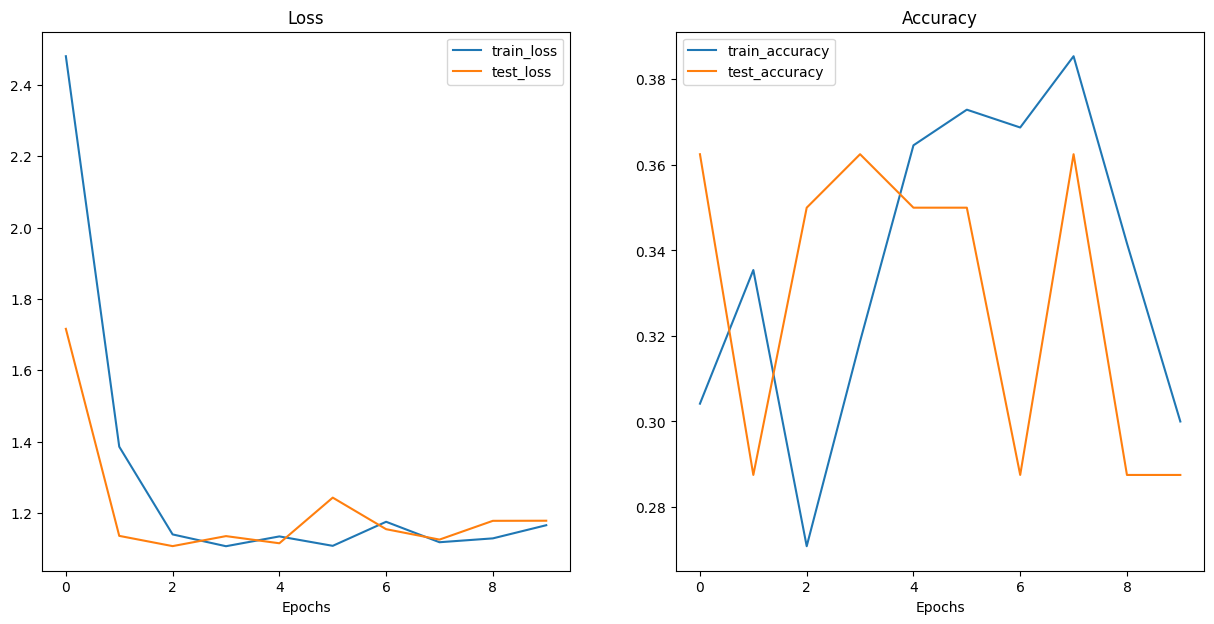

In [49]:
from helper_functions import plot_loss_curves
plot_loss_curves(results)

## 10 Pretraind ViT

In [50]:
print (torch.__version__)
print (torchvision.__version__)

2.3.0
0.18.0


In [51]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [57]:
!conda update openssl
!pip install --upgrade requests urllib3


^C
  Using cached requests-2.32.3-py3-none-any.whl.metadata (4.6 kB)
Using cached requests-2.32.3-py3-none-any.whl (64 kB)
   ---------------------------------------- 0.0/126.3 kB ? eta -:--:--
   --- ------------------------------------ 10.2/126.3 kB ? eta -:--:--
   ------------------- -------------------- 61.4/126.3 kB 1.1 MB/s eta 0:00:01
   ---------------------------------------- 126.3/126.3 kB 1.5 MB/s eta 0:00:00
  Attempting uninstall: urllib3
    Found existing installation: urllib3 2.2.2
    Uninstalling urllib3-2.2.2:
      Successfully uninstalled urllib3-2.2.2
  Attempting uninstall: requests
    Found existing installation: requests 2.32.2
    Uninstalling requests-2.32.2:
      Successfully uninstalled requests-2.32.2


In [63]:
pretrained_vit_weights = torchvision.models.ViT_B_16_Weights.DEFAULT

pretrained_vit =torchvision.models.vit_b_16(weights=pretrained_vit_weights).to(device)

# for parameter in pretrained_vit.parameters():
#     parameter.requires_grad = False

# pretrained_vit_weights().requires_grad_(False)
pretrained_vit.requires_grad_(False)

    
set_seeds()
pretrained_vit.heads = nn.Linear(in_features=768, out_features=len(class_names)).to(device)    

Downloading: "https://download.pytorch.org/models/vit_b_16-c867db91.pth" to C:\Users\Tiger/.cache\torch\hub\checkpoints\vit_b_16-c867db91.pth
100%|██████████| 330M/330M [00:11<00:00, 29.4MB/s] 


In [64]:
summary(model=pretrained_vit,
        input_size = (32, 3, 224, 224),
        col_names=['input_size', 'output_size', 'num_params', 'trainable'],
        col_width=20,
        row_settings=['var_names'])

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
VisionTransformer (VisionTransformer)                        [32, 3, 224, 224]    [32, 3]              768                  Partial
├─Conv2d (conv_proj)                                         [32, 3, 224, 224]    [32, 768, 14, 14]    (590,592)            False
├─Encoder (encoder)                                          [32, 197, 768]       [32, 197, 768]       151,296              False
│    └─Dropout (dropout)                                     [32, 197, 768]       [32, 197, 768]       --                   --
│    └─Sequential (layers)                                   [32, 197, 768]       [32, 197, 768]       --                   False
│    │    └─EncoderBlock (encoder_layer_0)                   [32, 197, 768]       [32, 197, 768]       (7,087,872)          False
│    │    └─EncoderBlock (encoder_layer_1)                   [32, 197, 768]       [32, 

In [65]:
image_path = Path('../data/pizza_steak_sushi_1')
train_dir = image_path /'train'
test_dir = image_path /'test'
train_dir, test_dir

(WindowsPath('../data/pizza_steak_sushi_1/train'),
 WindowsPath('../data/pizza_steak_sushi_1/test'))

In [66]:
pretrained_vit_transforms = pretrained_vit_weights.transforms()
print(pretrained_vit_transforms)

ImageClassification(
    crop_size=[224]
    resize_size=[256]
    mean=[0.485, 0.456, 0.406]
    std=[0.229, 0.224, 0.225]
    interpolation=InterpolationMode.BILINEAR
)


In [67]:
train_datalaoder_pretrain, \
test_data_loader_pretrain, \
class_names = data_loaders.create_dataloaders(train_dir=train_dir,
                                            test_dir =test_dir,
                                            transform= pretrained_vit_transforms,
                                            batch_size = 32)  

In [105]:
optimizer = torch.optim.Adam(params=pretrained_vit.parameters(),
                             lr = 1e-3)

lost_fn = torch.nn.CrossEntropyLoss()

set_seeds()
pretrained_vit_results = engine.train_model(model=pretrained_vit,
                                            train_dataloader=train_datalaoder_pretrain,
                                            test_dataloader=test_data_loader_pretrain,
                                            optimizer=optimizer,
                                            loss_fn=loss_fn,
                                            epochs=10,
                                            device=device)

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 1 |train_loss: 0.7663 |train_acc:0.7188 | test_loss: 0.5435 | test_acc: 0.8769


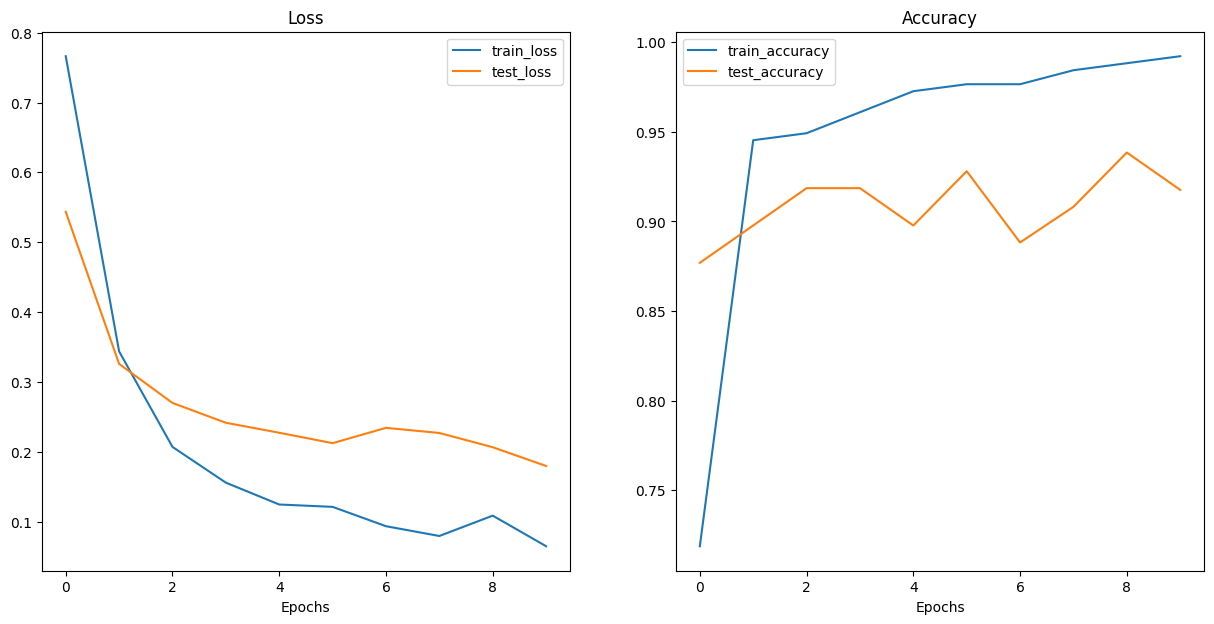

In [106]:
plot_loss_curves(pretrained_vit_results)

In [109]:
# save the model
# save_model(model=pretrained_vit,
#                  target_dir='models',
#                  model_name = '08_pretrained_vit_feature_extractor_pizza_steak_sushi.pth')

[INFO] Saving model to: models\08_pretrained_vit_feature_extractor_pizza_steak_sushi.pth


In [60]:


pretrained_vit_model_size = Path("models/08_pretrained_vit_feature_extractor_pizza_steak_sushi.pth").stat().st_size // (1024*1024)
print (f'pretained model size: {pretrained_vit_model_size} MB')


pretained model size: 327 MB


## make predictions with custom iamge

In [68]:
custom_image_path = image_path / '04-pizza-dad.jpg'
if not custom_image_path.is_file():
    with open (custom_image_path, 'wb') as f:
        request =requests.get("https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/images/04-pizza-dad.jpeg")
        print('downloading...')
        f.write(request.content)
    
    
    

In [77]:
import importlib
from going_modular import predictions

# Reload the predictions module
importlib.reload(predictions)


<module 'going_modular.predictions' from 'e:\\Dropbox\\GithubRepo\\Udemy\\pytorch-deep-learning-main\\pytorch-deep-learning-main - Copy\\MyProjects\\going_modular\\predictions.py'>

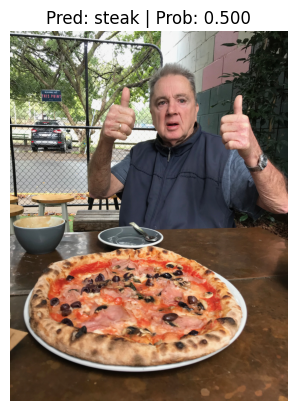

In [78]:
predictions.pred_and_plot_image (model=pretrained_vit,
                     image_path = custom_image_path,
                     class_names = class_names)